# Recognition of Yoga Postures

In [1]:
!nvidia-smi

Mon Aug 21 12:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   30C    P0    54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:90:00.0 Off |                    0 |
| N/A   

In [ ]:
# !kill -9 3582186

In [2]:
!pwd

/home/andrea.merov2/Yoga/3v detector-yoga-postures


In [3]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
#libraries to be used
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from utils import split_data
from fastai.vision.all import get_image_files,verify_images
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import categorical_crossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import datetime
from PIL import Image
from PIL import ImageOps
import Augmentor


In [5]:
# check if CUDA is available to use GPU on the training 
train_on_gpu = tf.config.list_physical_devices('GPU')
if train_on_gpu:
    print('GPU con soporte CUDA disponible')
else:
    print('No se encontró GPU con soporte CUDA')

GPU con soporte CUDA disponible


## Data preprocessing

In [6]:
images=get_image_files('home/andrea.merov2/Yoga/detector-yoga-postures/DATA')
images
failed = verify_images(images)
failed

(#0) []

In [49]:
def convert_images_in_folder(input_folder, output_folder, new_extension, target_size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpeg', '.gif', '.bmp')):
                img = Image.open(os.path.join(root, filename))
                
                # Convert images to RGB mode before saving as JPEG
                if img.mode in ('P', 'RGBA', 'LA'):
                    img = img.convert('RGB')
                
                # Resize the image to the target size
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                
                new_filename = os.path.splitext(filename)[0] + new_extension
                output_subfolder = os.path.relpath(root, input_folder)
                output_subfolder_path = os.path.join(output_folder, output_subfolder)
                
                if not os.path.exists(output_subfolder_path):
                    os.makedirs(output_subfolder_path)
                
                img.save(os.path.join(output_subfolder_path, new_filename), "JPEG", quality=100)
                img.close()

    print("Conversion completed.")



In [50]:
input_folder = "/home/andrea.merov2/Yoga/detector-yoga-postures/DATA"
output_folder = "/home/andrea.merov2/Yoga/detector-yoga-postures/newDATA"
new_extension = ".jpg"
target_size = (224, 224)

convert_images_in_folder(input_folder, output_folder, new_extension, target_size)

Conversion completed.


In [95]:
def augment_and_resize_images(input_folder, output_folder, new_extension, target_size, max_images):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_folder, class_folder)
            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)
            
            p = Augmentor.Pipeline(source_directory=class_path, output_directory=output_class_path)
            
            # Augmentation operations
            p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
            p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
            p.random_color(probability=0.5, min_factor=0.8, max_factor=1.2)
            p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)
            
            # Resize the augmented images
            p.resize(probability=1.0, width=target_size[0], height=target_size[1])
            
            # Generate up to max_images per class
            num_generated_images = min(max_images, len(os.listdir(class_path)))
            p.sample(num_generated_images)
            
            # Rename the augmented images
            new_filenames = [f"aug_{os.path.splitext(file)[0]}" for file in os.listdir(output_class_path)]
            for old_name, new_name in zip(os.listdir(output_class_path), new_filenames):
                os.rename(
                    os.path.join(output_class_path, old_name),
                    os.path.join(output_class_path, f"{new_name}.{new_extension}")
                )

            print(f"Augmentation, resizing, and renaming completed for class: {class_folder}")



In [96]:
input_folder = "/home/andrea.merov2/Yoga/detector-yoga-postures/newDATA"
output_folder = "/home/andrea.merov2/Yoga/detector-yoga-postures/augDATA"
new_extension = ".jpg"
target_size = (224, 224)
max_images = 3600

augment_and_resize_images(input_folder, output_folder, new_extension, target_size, max_images)

Initialised with 96 image(s) found.
Output directory set to /home/andrea.merov2/Yoga/detector-yoga-postures/augDATA/downdog.

Processing <PIL.Image.Image image mode=RGB size=224x224>: 100%|██████████| 96/96 [00:00<00:00, 262.26 Samples/s]


Augmentation, resizing, and renaming completed for class: downdog
Initialised with 86 image(s) found.
Output directory set to /home/andrea.merov2/Yoga/detector-yoga-postures/augDATA/plank.

Processing <PIL.Image.Image image mode=RGB size=224x224>: 100%|██████████| 86/86 [00:00<00:00, 249.88 Samples/s]


Augmentation, resizing, and renaming completed for class: plank
Initialised with 79 image(s) found.
Output directory set to /home/andrea.merov2/Yoga/detector-yoga-postures/augDATA/tree.

Processing <PIL.Image.Image image mode=RGB size=224x224>: 100%|██████████| 79/79 [00:00<00:00, 231.32 Samples/s]


Augmentation, resizing, and renaming completed for class: tree
Initialised with 75 image(s) found.
Output directory set to /home/andrea.merov2/Yoga/detector-yoga-postures/augDATA/warrior.

Processing <PIL.Image.Image image mode=RGB size=224x224>: 100%|██████████| 75/75 [00:00<00:00, 221.52 Samples/s]


Augmentation, resizing, and renaming completed for class: warrior


In [97]:
# Replace 'data' with the actual path to your data folder
data_path = '/home/andrea.merov2/Yoga/detector-yoga-postures/augDATA'


# List all subdirectories within the data folder
subdirectories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Modify filenames in each subdirectory
for subdir in subdirectories:
    subfolder_path = os.path.join(data_path, subdir)
    file_names = os.listdir(subfolder_path)
    
    for old_name in file_names:
        if old_name.endswith('.jpg'):
            new_name = old_name.split('_')[0] + old_name.split('_')[1] + old_name.split('_')[2] + old_name.split('_')[3] 
            old_path = os.path.join(subfolder_path, old_name)
            new_path = os.path.join(subfolder_path, new_name)
            os.rename(old_path, new_path)
#             print(f'Renamed: {old_name} -> {new_name}')



['downdog', 'plank', 'tree', 'warrior']


In [7]:
# Define paths for the images
downdog_SRC_DIR = "newDATA/downdog"
goddess_SRC_DIR = "newDATA/goddess"
plank_SRC_DIR = "newDATA/plank"
tree_SRC_DIR = "newDATA/tree"
warrior_SRC_DIR = "newDATA/warrior"
TRAINING_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
TEST_DIR = "dataset/test"
#splitting the dataset
TRAINING_DDG_DIR = os.path.join(TRAINING_DIR, "downdog/")
VALIDATION_DDG_DIR = os.path.join(VALIDATION_DIR, "downdog/")
TEST_DDG_DIR = os.path.join(TEST_DIR, "downdog/")

TRAINING_GDS_DIR = os.path.join(TRAINING_DIR, "goddess/")
VALIDATION_GDS_DIR = os.path.join(VALIDATION_DIR, "goddess/")
TEST_GDS_DIR = os.path.join(TEST_DIR, "goddess/")

TRAINING_PLANK_DIR = os.path.join(TRAINING_DIR, "plank/")
VALIDATION_PLANK_DIR = os.path.join(VALIDATION_DIR, "plank/")
TEST_PLANK_DIR = os.path.join(TEST_DIR, "plank/")

TRAINING_TREE_DIR = os.path.join(TRAINING_DIR, "tree/")
VALIDATION_TREE_DIR = os.path.join(VALIDATION_DIR, "tree/")
TEST_TREE_DIR = os.path.join(TEST_DIR, "tree/")

TRAINING_WR_DIR = os.path.join(TRAINING_DIR, "warrior/")
VALIDATION_WR_DIR = os.path.join(VALIDATION_DIR, "warrior/")
TEST_WR_DIR = os.path.join(TEST_DIR, "warrior/")

In [8]:
# Define proportion of images used for training
train_size = 0.8
val_size = 0.1
test_size = 0.1

split_data(downdog_SRC_DIR,
           TRAINING_DDG_DIR,
           VALIDATION_DDG_DIR,
           TEST_DDG_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(plank_SRC_DIR,
           TRAINING_PLANK_DIR,
           VALIDATION_PLANK_DIR,
           TEST_PLANK_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(tree_SRC_DIR,
           TRAINING_TREE_DIR,
           VALIDATION_TREE_DIR,
           TEST_TREE_DIR,
           split_ratio=(train_size,val_size, test_size))
split_data(warrior_SRC_DIR,
           TRAINING_WR_DIR,
           VALIDATION_WR_DIR,
           TEST_WR_DIR,
           split_ratio=(train_size,val_size, test_size))

Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.


In [9]:
print(f"Original Downdog directory has {len(os.listdir(downdog_SRC_DIR))} images")
print(f"Original Plank directory has {len(os.listdir(plank_SRC_DIR))} images")
print(f"Original Tree directory has {len(os.listdir(tree_SRC_DIR))} images")
print(f"Original Warrior directory has {len(os.listdir(warrior_SRC_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_DDG_DIR))} images of Dogdown for training")
print(f"There are {len(os.listdir(TRAINING_PLANK_DIR))} images of Plank for training")
print(f"There are {len(os.listdir(TRAINING_TREE_DIR))} images of Tree for training")
print(f"There are {len(os.listdir(TRAINING_WR_DIR))} images of Warrior for training\n")

print(f"There are {len(os.listdir(VALIDATION_DDG_DIR))} images of Dogdown for validation")           
print(f"There are {len(os.listdir(VALIDATION_PLANK_DIR))} images of Plank for validation")
print(f"There are {len(os.listdir(VALIDATION_TREE_DIR))} images of Tree for validation")
print(f"There are {len(os.listdir(VALIDATION_WR_DIR))} images of Warrior for validation\n")

print(f"There are {len(os.listdir(TEST_DDG_DIR))} images of Dogdown for test")
print(f"There are {len(os.listdir(TEST_PLANK_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_TREE_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_WR_DIR))} images of tree for test")

Original Downdog directory has 467 images
Original Plank directory has 755 images
Original Tree directory has 565 images
Original Warrior directory has 351 images

There are 373 images of Dogdown for training
There are 604 images of Plank for training
There are 452 images of Tree for training
There are 280 images of Warrior for training

There are 46 images of Dogdown for validation
There are 75 images of Plank for validation
There are 56 images of Tree for validation
There are 35 images of Warrior for validation

There are 48 images of Dogdown for test
There are 76 images of Plank for test
There are 57 images of Plank for test
There are 36 images of tree for test


In [10]:
# Definir un generador de imágenes con transformaciones
batch_size = 16
width=224
height=224
data_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6,1.0],
    validation_split=0.20
)
posture_names = ["downdog", "plank", "tree", "warrior"]

In [11]:
train_data = data_generator.flow_from_directory(
    TRAINING_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',  
    color_mode="rgb"
)

validation_data = data_generator.flow_from_directory(
    VALIDATION_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse',
)

test_data = data_generator.flow_from_directory(
    TEST_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse',
)


Found 1709 images belonging to 4 classes.
Found 212 images belonging to 4 classes.
Found 217 images belonging to 4 classes.


['downdog', 'plank', 'tree', 'warrior']


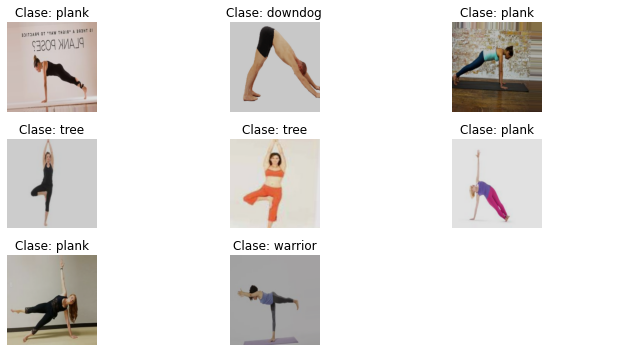

In [12]:
# Obtener un lote de imágenes y etiquetas del generador de datos
images, labels = next(train_data)

# Etiquetas de las clases (nombre de las carpetas)
class_labels = list(train_data.class_indices.keys())
print(class_labels)
# Configurar subplots
num_images = 8
num_cols = 3 # Número de columnas en la cuadrícula
num_rows = (num_images + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Iterar a través de las imágenes y subplots
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = images[i]
        label = class_labels[int(labels[i])]
        
        ax.imshow(image)
        ax.set_title(f"Clase: {label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:
def VGG19(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # Primera sección: 2x Conv -> MaxPool
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Segunda sección: 2x Conv -> MaxPool
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Tercera sección: 4x Conv -> MaxPool
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Cuarta sección: 4x Conv -> MaxPool
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Quinta sección: 4x Conv -> MaxPool
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Sección fully connected
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))#paso mas lento
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [14]:
class TransferNetVGG19(models.Model):
    def __init__(self, base_model_weights=None):
        super(TransferNetVGG19, self).__init__()
        self.base_model = tf.keras.applications.VGG19(include_top=False, weights=base_model_weights, input_shape=(224, 224, 3))
        for layer in self.base_model.layers:
            layer.trainable = False  # Freeze VGG19 layers initially
        self.flatten = layers.Flatten()
        
        # Simplified dense layers
        self.fc1 = layers.Dense(4096, activation='relu')
        self.fc2 = layers.Dense(4096, activation='relu')
        self.fc3 = layers.Dense(1024, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.3)
        self.fc4 = layers.Dense(32, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.3)
        self.fc5 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc_dropout1(x)
        x = self.fc3(x)
        x = self.fc_dropout2(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

    def get_config(self):
        return {"base_model_name": "VGG19"}

    @classmethod
    def from_config(cls, config):
        if config["base_model_name"] == "VGG19":
            return cls(base_model_weights="imagenet")


In [19]:
#model = Net()
#model = ImprovedNet()
#model = TransferNet()
#model = ModifiedTransferNetResNet()
#model= VGG19(input_shape=(250, 250, 3), num_classes=5)
model = TransferNetVGG19()

In [20]:
criterion = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0004)
EPOCHS=100

In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [22]:
model.compile(optimizer=optimizer, 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0, save_best_only=True)


In [24]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=validation_data.n//validation_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size
STEP_SIZE_TRAIN

106

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stopping, checkpoint,lr_schedule, tensorboard_callback]


In [26]:
history =model.fit(train_data,
    validation_data=validation_data,
     validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
 37/107 [=========>....................] - ETA: 22s - loss: 1.4402 - accuracy: 0.3361

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.3253

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 90s 824ms/step - loss: 1.3992 - accuracy: 0.3253 - val_loss: 1.3632 - val_accuracy: 0.3510 - lr: 4.0000e-04
Epoch 2/100
 15/107 [===>..........................] - ETA: 29s - loss: 1.3812 - accuracy: 0.3713

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.3718 - accuracy: 0.3370

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 60s 559ms/step - loss: 1.3718 - accuracy: 0.3370 - val_loss: 1.3502 - val_accuracy: 0.3558 - lr: 4.0000e-04
Epoch 3/100
  2/107 [..............................] - ETA: 32s - loss: 1.2952 - accuracy: 0.4375

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 48s 447ms/step - loss: 1.3556 - accuracy: 0.3382 - val_loss: 1.3541 - val_accuracy: 0.3510 - lr: 4.0000e-04
Epoch 4/100
107/107 [==============================] - ETA: 0s - loss: 1.3447 - accuracy: 0.3511

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 62s 578ms/step - loss: 1.3447 - accuracy: 0.3511 - val_loss: 1.3381 - val_accuracy: 0.3510 - lr: 4.0000e-04
Epoch 5/100
 37/107 [=========>....................] - ETA: 21s - loss: 1.3392 - accuracy: 0.3277

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.3253 - accuracy: 0.3540

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 59s 555ms/step - loss: 1.3253 - accuracy: 0.3540 - val_loss: 1.2994 - val_accuracy: 0.3558 - lr: 4.0000e-04
Epoch 6/100
  9/107 [=>............................] - ETA: 30s - loss: 1.3219 - accuracy: 0.3611

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.2933 - accuracy: 0.3932

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 59s 556ms/step - loss: 1.2933 - accuracy: 0.3932 - val_loss: 1.2736 - val_accuracy: 0.3846 - lr: 4.0000e-04
Epoch 7/100
 28/107 [======>.......................] - ETA: 24s - loss: 1.2801 - accuracy: 0.3884

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 48s 453ms/step - loss: 1.2708 - accuracy: 0.4178 - val_loss: 1.4167 - val_accuracy: 0.2740 - lr: 4.0000e-04
Epoch 8/100
107/107 [==============================] - ETA: 0s - loss: 1.2075 - accuracy: 0.4564

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 61s 568ms/step - loss: 1.2075 - accuracy: 0.4564 - val_loss: 1.2179 - val_accuracy: 0.4760 - lr: 4.0000e-04
Epoch 9/100
 18/107 [====>.........................] - ETA: 28s - loss: 1.1527 - accuracy: 0.5069

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.0954 - accuracy: 0.5407

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 62s 578ms/step - loss: 1.0954 - accuracy: 0.5407 - val_loss: 1.0485 - val_accuracy: 0.5529 - lr: 4.0000e-04
Epoch 10/100
 21/107 [====>.........................] - ETA: 28s - loss: 1.1091 - accuracy: 0.5195

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.5606

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 63s 589ms/step - loss: 1.0617 - accuracy: 0.5606 - val_loss: 0.9811 - val_accuracy: 0.5817 - lr: 4.0000e-04
Epoch 11/100
 27/107 [======>.......................] - ETA: 25s - loss: 1.0650 - accuracy: 0.5245

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.5553

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 59s 548ms/step - loss: 1.0242 - accuracy: 0.5553 - val_loss: 0.9769 - val_accuracy: 0.6010 - lr: 3.6193e-04
Epoch 12/100
  3/107 [..............................] - ETA: 32s - loss: 0.9629 - accuracy: 0.5625

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 48s 445ms/step - loss: 0.9956 - accuracy: 0.5816 - val_loss: 0.9989 - val_accuracy: 0.5481 - lr: 3.2749e-04
Epoch 13/100
107/107 [==============================] - 48s 448ms/step - loss: 0.9572 - accuracy: 0.5875 - val_loss: 1.0496 - val_accuracy: 0.5481 - lr: 2.9633e-04
Epoch 14/100
107/107 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.6009

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 58s 545ms/step - loss: 0.9589 - accuracy: 0.6009 - val_loss: 0.9015 - val_accuracy: 0.6154 - lr: 2.6813e-04
Epoch 15/100
 22/107 [=====>........................] - ETA: 26s - loss: 0.9699 - accuracy: 0.5559

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 0.9338 - accuracy: 0.5998

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 58s 546ms/step - loss: 0.9338 - accuracy: 0.5998 - val_loss: 0.8752 - val_accuracy: 0.6250 - lr: 2.4261e-04
Epoch 16/100
  9/107 [=>............................] - ETA: 29s - loss: 0.9201 - accuracy: 0.6312

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 47s 443ms/step - loss: 0.9063 - accuracy: 0.6150 - val_loss: 0.9410 - val_accuracy: 0.5913 - lr: 2.1952e-04
Epoch 17/100
107/107 [==============================] - 47s 442ms/step - loss: 0.9054 - accuracy: 0.6238 - val_loss: 0.9510 - val_accuracy: 0.5913 - lr: 1.9863e-04
Epoch 18/100
107/107 [==============================] - 47s 441ms/step - loss: 0.9071 - accuracy: 0.6074 - val_loss: 0.8988 - val_accuracy: 0.6250 - lr: 1.7973e-04
Epoch 19/100
107/107 [==============================] - 48s 447ms/step - loss: 0.9039 - accuracy: 0.6138 - val_loss: 0.9213 - val_accuracy: 0.6058 - lr: 1.6263e-04
Epoch 20/100
107/107 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.6144

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 60s 567ms/step - loss: 0.8722 - accuracy: 0.6144 - val_loss: 0.8490 - val_accuracy: 0.5962 - lr: 1.4715e-04
Epoch 21/100
 40/107 [==========>...................] - ETA: 20s - loss: 0.8613 - accuracy: 0.6406

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 47s 442ms/step - loss: 0.8620 - accuracy: 0.6349 - val_loss: 0.8507 - val_accuracy: 0.6202 - lr: 1.3315e-04
Epoch 22/100
107/107 [==============================] - 47s 440ms/step - loss: 0.8589 - accuracy: 0.6390 - val_loss: 0.8543 - val_accuracy: 0.6250 - lr: 1.2048e-04
Epoch 23/100
107/107 [==============================] - 48s 446ms/step - loss: 0.8605 - accuracy: 0.6156 - val_loss: 0.8700 - val_accuracy: 0.5865 - lr: 1.0901e-04
Epoch 24/100
107/107 [==============================] - 48s 445ms/step - loss: 0.8573 - accuracy: 0.6343 - val_loss: 0.8662 - val_accuracy: 0.6298 - lr: 9.8639e-05
Epoch 25/100
107/107 [==============================] - 47s 442ms/step - loss: 0.8328 - accuracy: 0.6407 - val_loss: 0.9032 - val_accuracy: 0.6010 - lr: 8.9252e-05
Epoch 26/100
107/107 [==============================] - 48s 445ms/step - loss: 0.8490 - accuracy: 0.6378 - val_loss: 0.8616 - val_accuracy: 0.6298 - lr: 8.0759e-05
Epoch 27/100
107/107 [=======

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 57s 539ms/step - loss: 0.8255 - accuracy: 0.6419 - val_loss: 0.8469 - val_accuracy: 0.6202 - lr: 7.3073e-05
Epoch 28/100
  1/107 [..............................] - ETA: 47s - loss: 1.0907 - accuracy: 0.6250

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.6331

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 59s 553ms/step - loss: 0.8327 - accuracy: 0.6331 - val_loss: 0.8011 - val_accuracy: 0.6442 - lr: 6.6119e-05
Epoch 29/100
 62/107 [================>.............] - ETA: 14s - loss: 0.8375 - accuracy: 0.6280

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 47s 444ms/step - loss: 0.8273 - accuracy: 0.6437 - val_loss: 0.8563 - val_accuracy: 0.6250 - lr: 5.9827e-05
Epoch 30/100
107/107 [==============================] - 47s 442ms/step - loss: 0.8410 - accuracy: 0.6396 - val_loss: 0.8091 - val_accuracy: 0.6298 - lr: 5.4134e-05
Epoch 31/100
107/107 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.6460

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 59s 549ms/step - loss: 0.8330 - accuracy: 0.6460 - val_loss: 0.7938 - val_accuracy: 0.6490 - lr: 4.8983e-05
Epoch 32/100
 21/107 [====>.........................] - ETA: 26s - loss: 0.8470 - accuracy: 0.6458

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 48s 446ms/step - loss: 0.8200 - accuracy: 0.6489 - val_loss: 0.8524 - val_accuracy: 0.6250 - lr: 4.4321e-05
Epoch 33/100
107/107 [==============================] - 47s 438ms/step - loss: 0.8278 - accuracy: 0.6507 - val_loss: 0.8348 - val_accuracy: 0.6202 - lr: 4.0103e-05
Epoch 34/100
107/107 [==============================] - 48s 449ms/step - loss: 0.8007 - accuracy: 0.6577 - val_loss: 0.8005 - val_accuracy: 0.6250 - lr: 3.6287e-05
Epoch 35/100
107/107 [==============================] - 48s 448ms/step - loss: 0.8054 - accuracy: 0.6571 - val_loss: 0.8201 - val_accuracy: 0.6442 - lr: 3.2834e-05
Epoch 36/100
107/107 [==============================] - 47s 445ms/step - loss: 0.8030 - accuracy: 0.6530 - val_loss: 0.8341 - val_accuracy: 0.6202 - lr: 2.9709e-05
Epoch 37/100
107/107 [==============================] - 48s 445ms/step - loss: 0.7988 - accuracy: 0.6501 - val_loss: 0.8038 - val_accuracy: 0.6538 - lr: 2.6882e-05
Epoch 38/100
107/107 [=======

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


107/107 [==============================] - 58s 539ms/step - loss: 0.8167 - accuracy: 0.6472 - val_loss: 0.7652 - val_accuracy: 0.6635 - lr: 2.4324e-05
Epoch 39/100
 44/107 [===========>..................] - ETA: 19s - loss: 0.8254 - accuracy: 0.6520

/home/andrea.merov2/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 47s 444ms/step - loss: 0.8342 - accuracy: 0.6489 - val_loss: 0.7881 - val_accuracy: 0.6587 - lr: 2.2009e-05
Epoch 40/100
107/107 [==============================] - 47s 440ms/step - loss: 0.8166 - accuracy: 0.6507 - val_loss: 0.8329 - val_accuracy: 0.6298 - lr: 1.9915e-05
Epoch 41/100
107/107 [==============================] - 48s 446ms/step - loss: 0.7969 - accuracy: 0.6647 - val_loss: 0.8816 - val_accuracy: 0.6154 - lr: 1.8020e-05
Epoch 42/100
107/107 [==============================] - 48s 445ms/step - loss: 0.8265 - accuracy: 0.6401 - val_loss: 0.7720 - val_accuracy: 0.6490 - lr: 1.6305e-05
Epoch 43/100
107/107 [==============================] - 47s 444ms/step - loss: 0.8016 - accuracy: 0.6577 - val_loss: 0.8394 - val_accuracy: 0.6346 - lr: 1.4753e-05
Epoch 44/100
107/107 [==============================] - 48s 446ms/step - loss: 0.8092 - accuracy: 0.6507 - val_loss: 0.7809 - val_accuracy: 0.6683 - lr: 1.3349e-05
Epoch 45/100
107/107 [=======

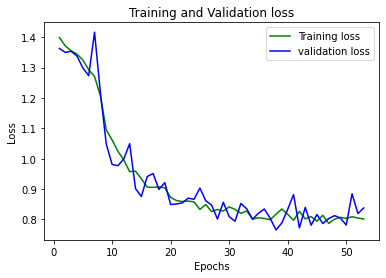

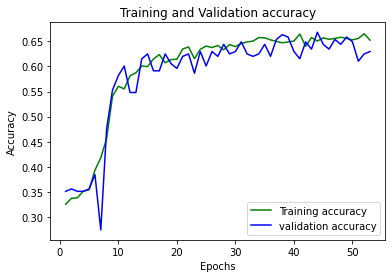

In [27]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs_loss_train = range(1,len(loss_train)+1)
epochs_loss_val = range(1,len(loss_val)+1)
plt.plot(epochs_loss_train, loss_train, 'g', label='Training loss')
plt.plot(epochs_loss_val, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs_loss_train = range(1,len(loss_train)+1)
epochs_loss_val = range(1,len(loss_val)+1)
plt.plot(epochs_loss_train, loss_train, 'g', label='Training accuracy')
plt.plot(epochs_loss_val, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
len(loss_val)

53

In [28]:
model.summary()

Model: "transfer_net_vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  102764544 
                                                                 
 dense_1 (Dense)             multiple                  16781312  
                                                                 
 dense_2 (Dense)             multiple                  4195328   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_3 (Dense)             multiple           

In [29]:
model.save_weights('yoga_vgg19v50.h5')

14/14 [==============================] - 5s 335ms/step


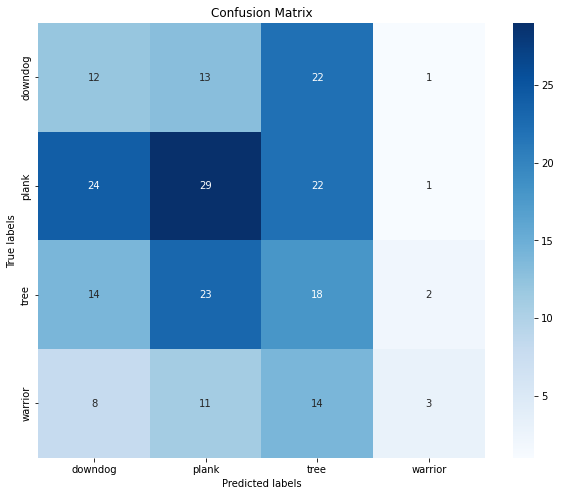

In [30]:
# Obtener las predicciones del modelo
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calcular la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
from keras_tuner import HyperModel

class TransferNetTuner(HyperModel):
    def __init__(self, base_model_weights=None):
        self.base_model_weights = base_model_weights


In [37]:
def build_model(hp):
        model = TransferNet(base_model_weights='imagenet')
        
       # Hiperparámetro para el learning rate
        lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)

        # Hiperparámetro para el optimizador
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

        # Compilación del modelo
        if optimizer == 'adam':
                opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
                opt = tf.keras.optimizers.SGD(learning_rate=lr)
        elif optimizer == 'rmsprop':
                opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

        model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

In [38]:
from keras_tuner.tuners import RandomSearch

# Usar solo la mitad de los datos para acelerar la búsqueda

half_steps_per_epoch = int(STEP_SIZE_TRAIN / 2)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search_dir',
    project_name='project_name_here'
)


tuner.search(train_data,
             validation_data=validation_data,
            steps_per_epoch=half_steps_per_epoch,
             epochs=5,
             callbacks=[early_stopping])


NameError: name 'TransferNet' is not defined